In [ ]:
import corner, torch, os, sys, json
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTConfig, ViTModel, TrainingArguments
sys.path.append("../scripts/")
from TrainerWithDropout import DropoutTrainer
from ViTwithNLL import NLLViT
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
out_name = "20230725_vit_DES"

subset = "test"
labels = ["H0", "Ob", "Om", "ns", "s8", "w0"]
size = (224, 224)
per_device_train_batch_size = 128
per_device_eval_batch_size = 256
num_epochs = 300
learning_rate = 5e-5
weight_decay_rate = 0.001

num_channels = 40

data = load_dataset("../data/fiducial_224x224/fiducial_224x224.py", "old_DES",
                    cache_dir="/data2/shared/shubh/cache")

id2label = {**{labels.index(label):label for label in labels}, \
                **{(len(labels)+labels.index(label)): "ln_sig_" + label for label in labels}}
label2id = {label:id for id,label in id2label.items()}

checkpoint = "google/vit-base-patch16-224-in21k"
model = NLLViT.from_pretrained(checkpoint,
            problem_type = "regression", id2label=id2label, label2id=label2id, hidden_dropout_prob=0.1,
            num_channels=num_channels, image_size=224, patch_size=16, ignore_mismatched_sizes=True)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor(np.array([example["labels"] for example in examples]))
    return {"pixel_values": pixel_values, "labels": labels}

args = TrainingArguments(
        f"./new/temp/{out_name}",
        save_strategy="epoch",
        evaluation_strategy="epoch",
        num_train_epochs=num_epochs,
        weight_decay=weight_decay_rate,
        load_best_model_at_end=True,
        logging_dir='logs',
        remove_unused_columns=False,
        per_device_train_batch_size = per_device_train_batch_size,
        per_device_eval_batch_size = per_device_eval_batch_size,
)

trainer = DropoutTrainer(
        model,
        args,
        data_collator=collate_fn
    )

In [ ]:
chkpts = os.listdir("../temp/" + out_name)
chkpts = [int(chkpt.split("-")[1]) for chkpt in chkpts if "checkpoint" in chkpt]
highest_chkpt = max(chkpts)
print("Highest checkpoint:", highest_chkpt)
with open(f"../temp/{out_name}/checkpoint-{highest_chkpt}/trainer_state.json", "r") as f:
    checkpoint_path = json.load(f)['best_model_checkpoint'] + "/pytorch_model.bin"

print("Loading model from", checkpoint_path)

trainer.model.load_state_dict(torch.load(os.path.join("..", checkpoint_path), 
                              map_location=torch.device('cpu')))

In [ ]:
n_pred = 10
preds = np.empty((n_pred, len(data["test"]), len(labels)*2))

for ind in range(n_pred):
    print(ind)
    ps = trainer.predict(data["test"])
    preds[i] = ps.predictions
    if i == 0:
        label_ids = ps.label_ids

In [ ]:
n_preds_per_sample = 100
predictions = np.empty((preds_best.shape[0] * n_preds_per_sample, preds_best.shape[1], preds_best.shape[2]))
for i in range(preds_best.shape[0]):
    for j in range(n_preds_per_sample):
        predictions[i*n_preds_per_sample+j] = np.random.normal(preds_best[i], np.exp(preds_std[i]))

# corner

In [37]:
import corner, os
import numpy as np

In [38]:
out_name = "20230725_vit_DES"
preds = np.load(f"../models/fiducial/{out_name}/preds0.npy")
label = np.load(f"../models/fiducial/{out_name}/label_ids0.npy")[0]
preds = preds.reshape(preds.shape[0]*preds.shape[1], preds.shape[2])[:, :6]
# preds = np.median(preds[:, :, :6], axis=0)

In [39]:
preds.shape

(2000, 6)

1

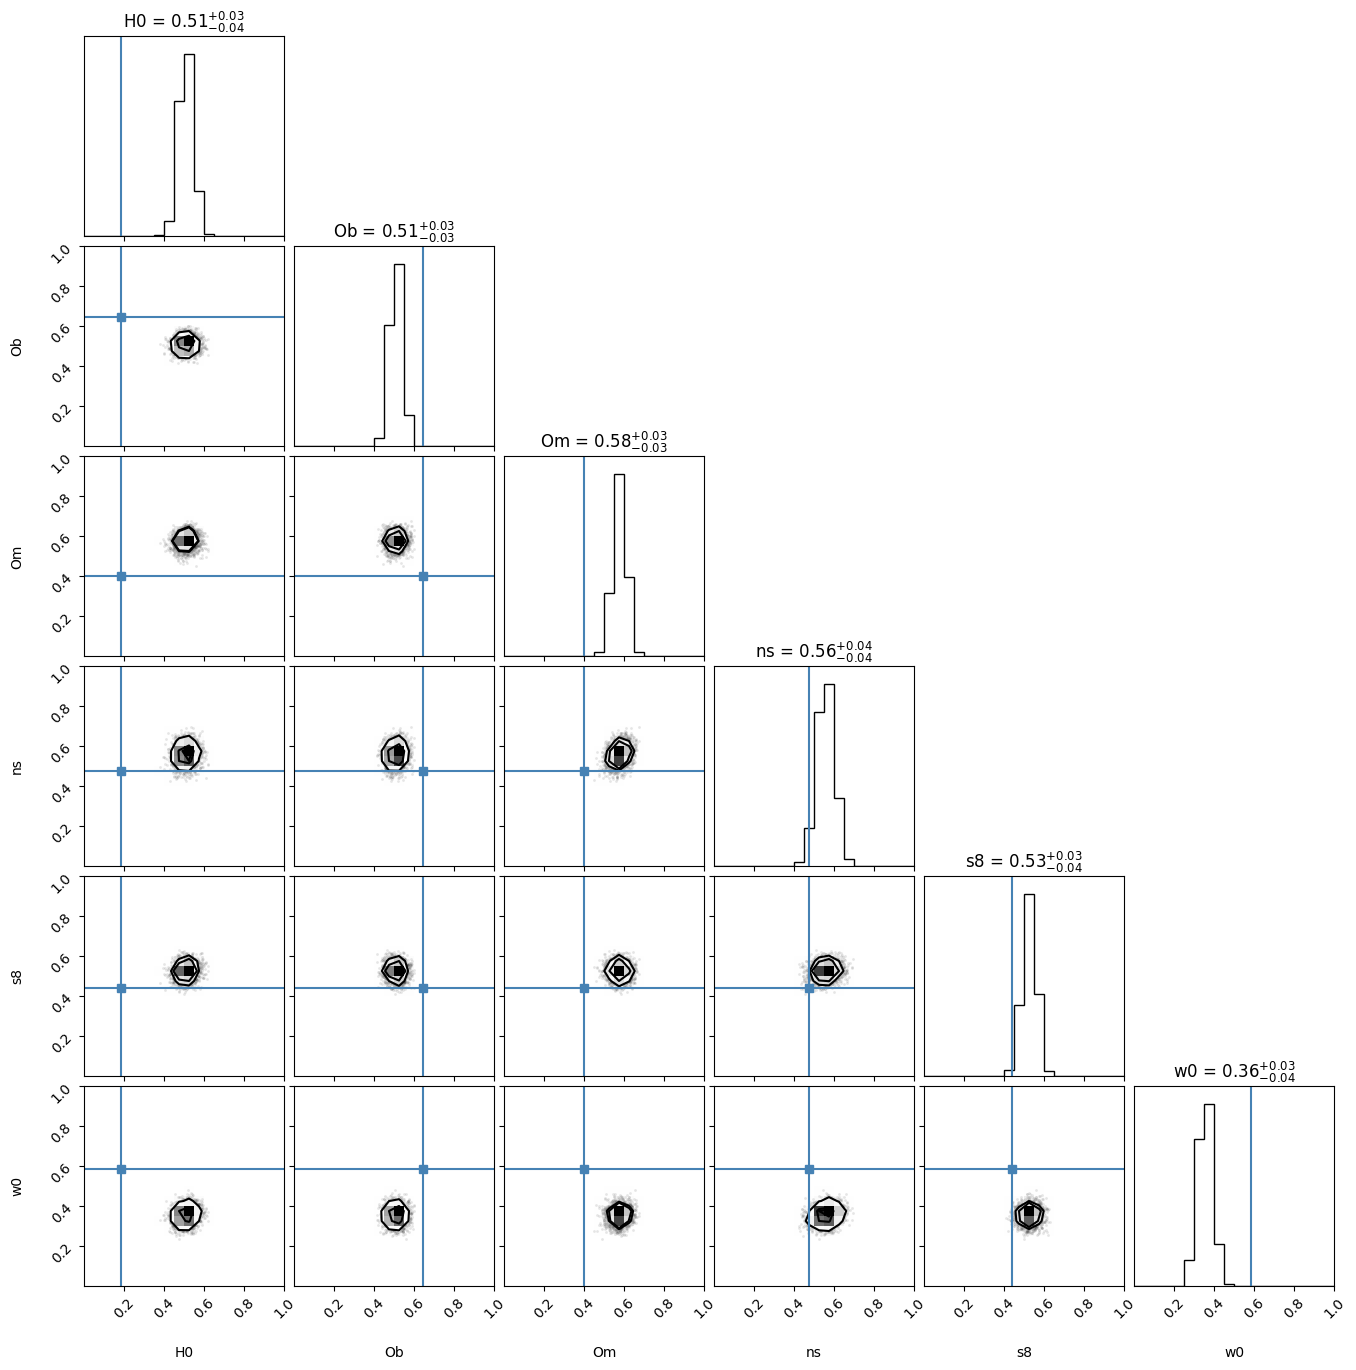

In [40]:
corner.corner(preds, truths=label, labels=["H0", "Ob", "Om", "ns", "s8", "w0"], \
    show_titles=True, range=[(0, 1)] * 6)
1

1

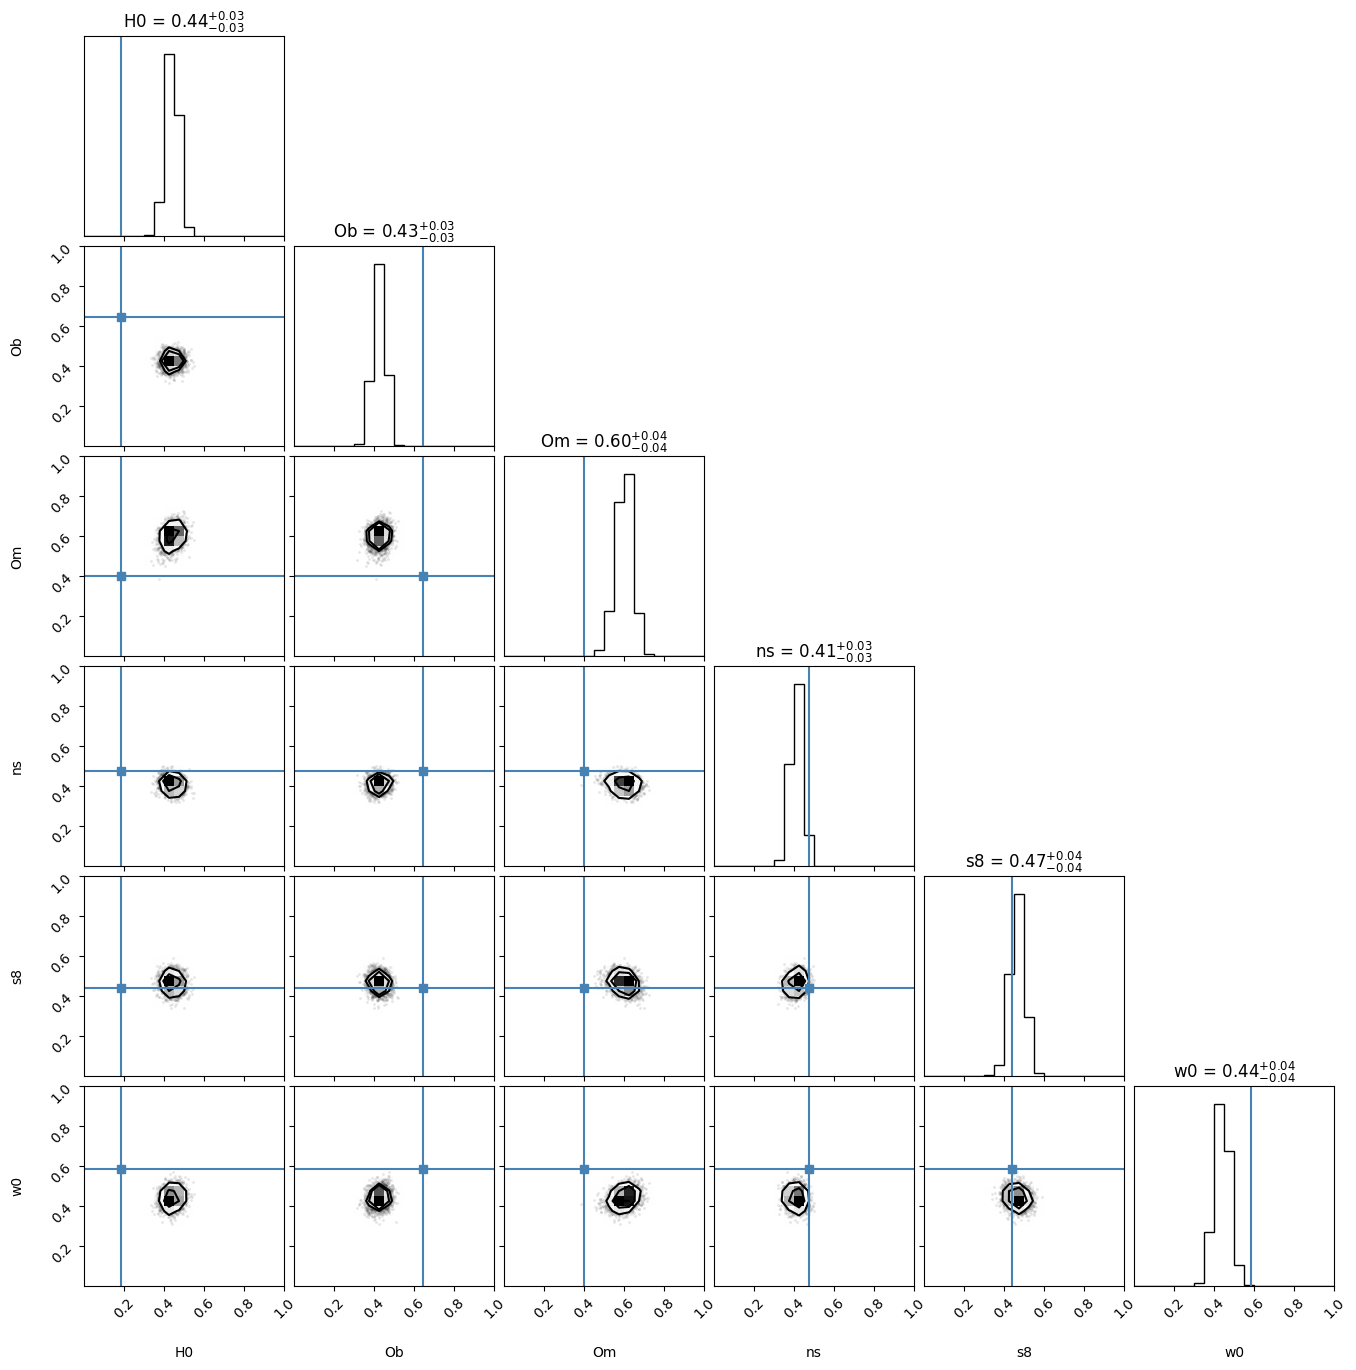

In [36]:
corner.corner(preds, truths=label, labels=["H0", "Ob", "Om", "ns", "s8", "w0"], \
    show_titles=True, range=[(0, 1)] * 6)
1